# NBEATS MODEL

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/120, Train Loss: 27.57223, Valid Loss: 0.00238
Epoch 2/120, Train Loss: 0.41250, Valid Loss: 0.00934
Epoch 3/120, Train Loss: 0.09178, Valid Loss: 0.00212
Epoch 4/120, Train Loss: 0.01593, Valid Loss: 0.06899
Epoch 5/120, Train Loss: 0.01367, Valid Loss: 0.00878
Epoch 6/120, Train Loss: 0.00656, Valid Loss: 0.00165
Epoch 7/120, Train Loss: 0.00279, Valid Loss: 0.00450
Epoch 8/120, Train Loss: 0.00131, Valid Loss: 0.01389
Epoch 9/120, Train Loss: 0.00117, Valid Loss: 0.00401
Epoch 10/120, Train Loss: 0.00088, Valid Loss: 0.00038
Epoch 11/120, Train Loss: 0.00034, Valid Loss: 0.00024
Epoch 12/120, Train Loss: 0.00042, Valid Loss: 0.00021
Epoch 13/120, Train Loss: 0.00032, Valid Loss: 0.00024
Epoch 14/120, Train Loss: 0.00035, Valid Loss: 0.00349
Epoch 15/120, Train Loss: 0.00043, Valid Loss: 0.00050
Epoch 16/120, Train Loss: 0.00027, Valid Loss: 0.00022
Epoch 17/120, Train Loss: 0.00030, Valid Loss: 0.00331
Epoch 18/120, Train Loss: 0.00074, Valid Loss: 0.00623
Epoch 19/120, Trai

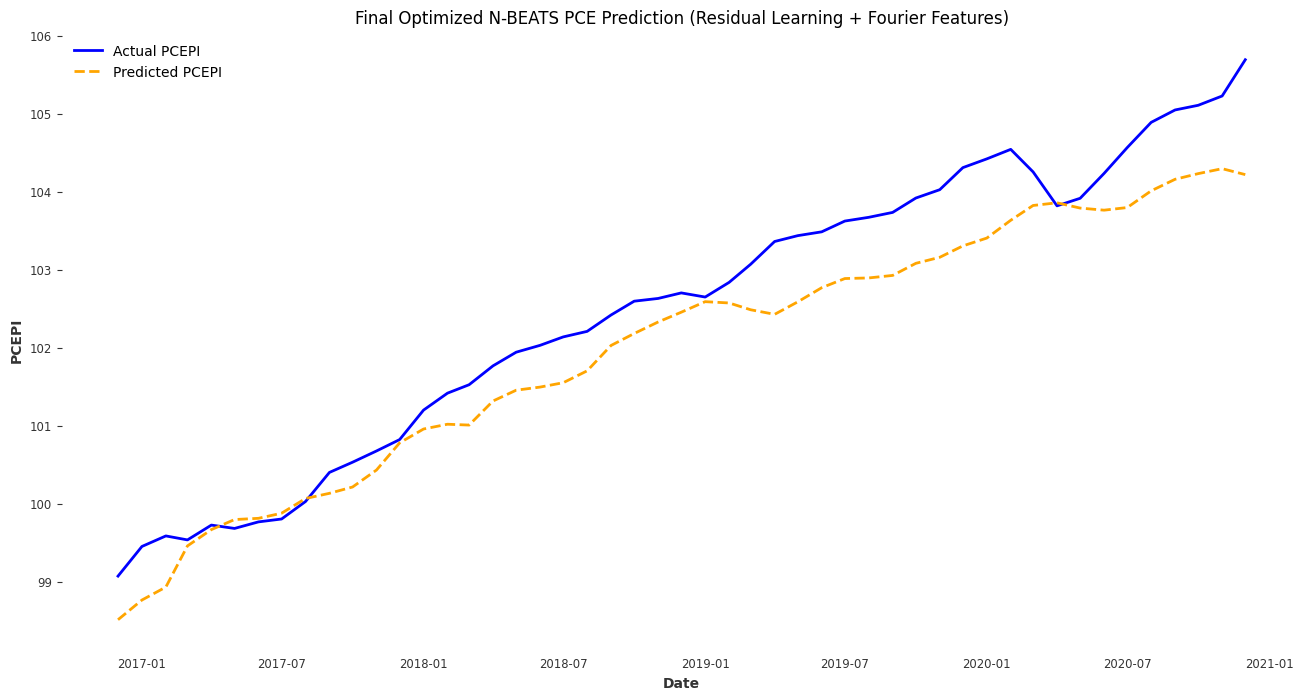

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from scipy.fftpack import fft
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load and Format Data for N-BEATS
def load_data(train_file, sequence_length=48):
    df = pd.read_csv(train_file)
    df["observation_date"] = pd.to_datetime(df["observation_date"], format="%m/%Y")
    df = df.sort_values(by="observation_date").reset_index(drop=True)

    target_col = "fred_PCEPI"
    data = df[[target_col]].values.astype(np.float32)

    # Compute Fourier Transform Features for Seasonality
    fft_features = np.abs(fft(data.flatten()))[:sequence_length]
    fft_features = (fft_features - np.min(fft_features)) / (np.max(fft_features) - np.min(fft_features))

    # Create Sequences (Past sequence_length Months → Next Month)
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(np.hstack([data[i : i + sequence_length].flatten(), fft_features]))  
        y.append(data[i + sequence_length])  

    X, y = np.array(X), np.array(y)

    # Train-Validation-Test Split (70%-15%-15%)
    train_idx = int(len(X) * 0.7)
    valid_idx = int(len(X) * 0.85)

    X_train, y_train = X[:train_idx], y[:train_idx]
    X_valid, y_valid = X[train_idx:valid_idx], y[train_idx:valid_idx]
    X_test, y_test = X[valid_idx:], y[valid_idx:]

    # Fix Data Leakage: Scale After Splitting
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)
    X_test = scaler.transform(X_test)

    y_scaler = MinMaxScaler()
    y_train = y_scaler.fit_transform(y_train.reshape(-1, 1))
    y_valid = y_scaler.transform(y_valid.reshape(-1, 1))
    y_test = y_scaler.transform(y_test.reshape(-1, 1))

    return X_train, y_train, X_valid, y_valid, X_test, y_test, df["observation_date"][sequence_length:], scaler, y_scaler

# Convert Data to PyTorch Tensors
def prepare_dataloader(X, y, batch_size=32):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# N-BEATS Model with Residual Learning
class ResidualBlock(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ResidualBlock, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.LeakyReLU(0.1),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.1),
            nn.Linear(hidden_size, output_size)
        )
        self.residual = nn.Linear(input_size, output_size)  # Residual connection

    def forward(self, x):
        x = x.view(x.shape[0], -1)  
        return self.hidden(x) + self.residual(x)  # Residual Learning

class NBeats(nn.Module):
    def __init__(self, input_size, hidden_size=512, output_size=1):
        super(NBeats, self).__init__()
        self.trend_block = ResidualBlock(input_size, hidden_size, output_size)
        self.seasonality_block = ResidualBlock(input_size, hidden_size, output_size)
        self.skip = nn.Linear(input_size, output_size)  # Skip connection

    def forward(self, x):
        trend = self.trend_block(x)
        seasonality = self.seasonality_block(x)
        skip_connection = self.skip(x.view(x.shape[0], -1))  # Shortcut
        return trend + seasonality + skip_connection

# Load Data and Create Model
train_file = "../Data/Train/train1990s.csv"
X_train, y_train, X_valid, y_valid, X_test, y_test, dates, scaler, y_scaler = load_data(train_file)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NBeats(input_size=X_train.shape[1]).to(device)

# Prepare DataLoaders
dataloader_train = prepare_dataloader(X_train, y_train)
dataloader_valid = prepare_dataloader(X_valid, y_valid)
dataloader_test = prepare_dataloader(X_test, y_test)

# Training Setup
loss_fn = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.005, weight_decay=5e-7)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Train the Optimized N-BEATS Model with Early Stopping
def train_model(model, train_loader, valid_loader, loss_fn, optimizer, scheduler, device, max_epochs=120):
    model.train()
    best_valid_loss = float("inf")
    patience, patience_counter = 15, 0

    for epoch in range(max_epochs):
        train_loss, valid_loss = 0, 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = loss_fn(predictions, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in valid_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                predictions = model(X_batch)
                loss = loss_fn(predictions, y_batch)
                valid_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        avg_valid_loss = valid_loss / len(valid_loader)
        print(f"Epoch {epoch+1}/{max_epochs}, Train Loss: {avg_train_loss:.5f}, Valid Loss: {avg_valid_loss:.5f}")

        # Pass validation loss to scheduler
        scheduler.step(avg_valid_loss)

        if avg_valid_loss < best_valid_loss:
            best_valid_loss = avg_valid_loss
            torch.save(model.state_dict(), "best_nbeats.pth")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break

train_model(model, dataloader_train, dataloader_valid, loss_fn, optimizer, scheduler, device, max_epochs=120)

# Load Best Model and Evaluate on Test Set
model.load_state_dict(torch.load("best_nbeats.pth"))
model.eval()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
predictions = model(X_test_tensor).detach().cpu().numpy()

# Convert Predictions Back to Original Scale
predictions = y_scaler.inverse_transform(predictions)
y_test_original = y_scaler.inverse_transform(y_test)

# Final Improved Graph
plt.figure(figsize=(16, 8))
plt.plot(dates[-len(y_test_original):], y_test_original, label="Actual PCEPI", color="blue", linewidth=2)
plt.plot(dates[-len(predictions):], predictions, label="Predicted PCEPI", linestyle="dashed", color="orange", linewidth=2)
plt.xlabel("Date")
plt.ylabel("PCEPI")
plt.title("Final Optimized N-BEATS PCE Prediction (Residual Learning + Fourier Features)")
plt.legend()
plt.grid()
plt.show()


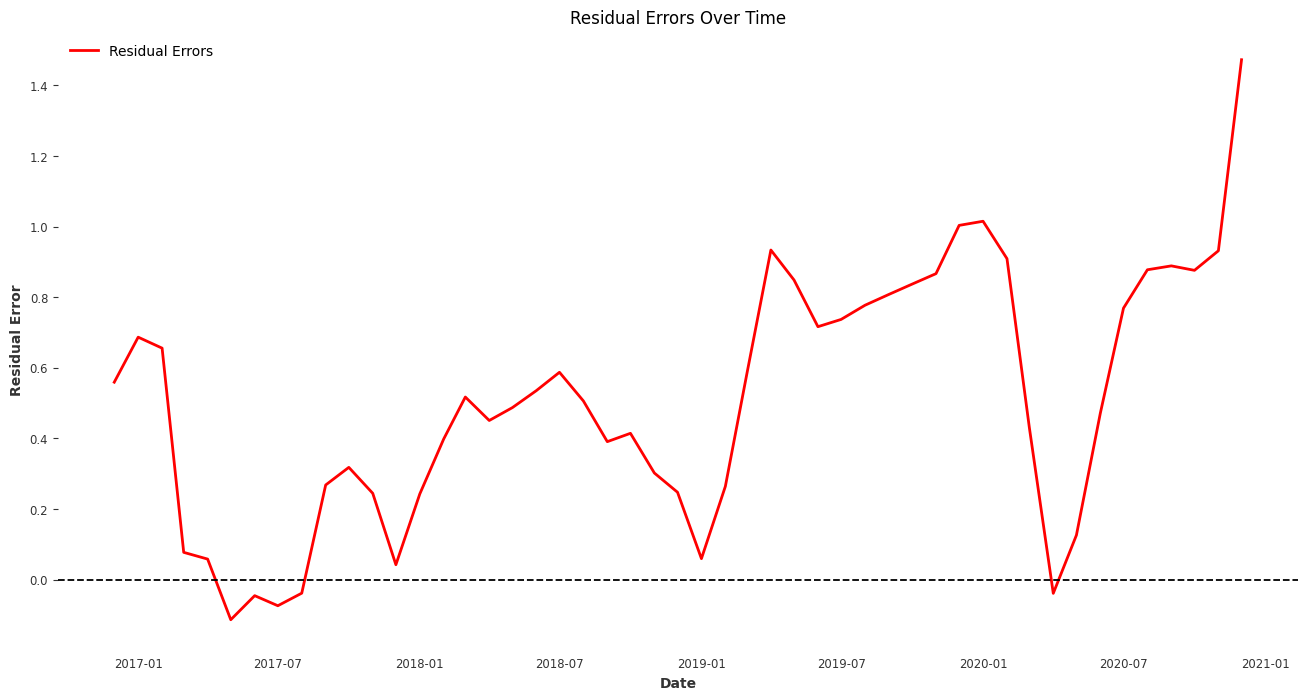

Mean Absolute Error (MAE): 0.52036
Root Mean Square Error (RMSE): 0.61908


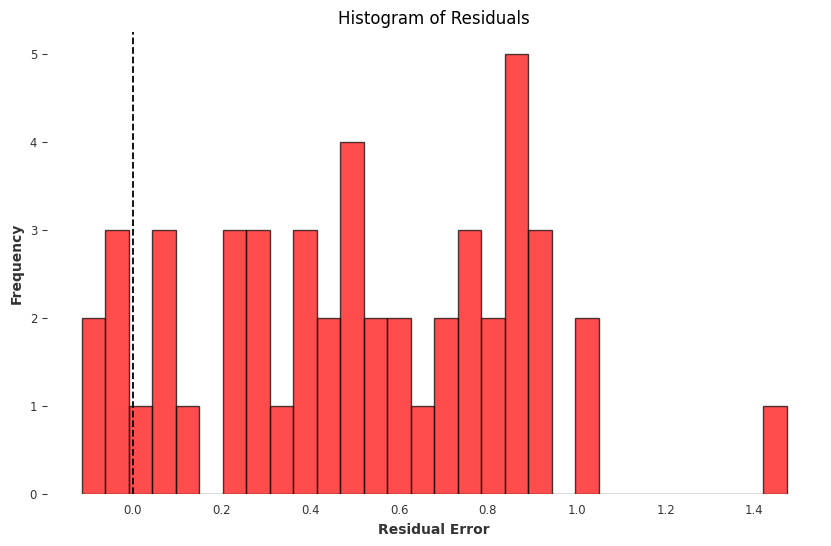

In [18]:
# Compute residual errors
residuals = y_test_original - predictions
plt.figure(figsize=(16, 8))
plt.plot(dates[-len(residuals):], residuals, label="Residual Errors", color="red", linewidth=2)
plt.axhline(y=0, color='black', linestyle='dashed')  # Reference line at 0
plt.xlabel("Date")
plt.ylabel("Residual Error")
plt.title("Residual Errors Over Time")
plt.legend()
plt.grid()
plt.show()

from sklearn.metrics import mean_absolute_error, mean_squared_error

# Compute MAE
mae = mean_absolute_error(y_test_original, predictions)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_test_original, predictions))

print(f"Mean Absolute Error (MAE): {mae:.5f}")
print(f"Root Mean Square Error (RMSE): {rmse:.5f}")

plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='black', color='red', alpha=0.7)
plt.xlabel("Residual Error")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.axvline(x=0, color='black', linestyle='dashed')  # Reference line at 0
plt.grid()
plt.show()




2025-03-22 20:46:53,912 - INFO - Train dataset contains 223 samples.
2025-03-22 20:46:54,025 - INFO - Time series values are 64-bits; casting model to float64.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.6 M  | train
-------------------------------------------------------------
6.6 M     Trainable params
1.7 K     Non-trainable params
6.6 M     Total params
26.290    Total estimated model params size (MB)
486       Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 14/14 [00:01<00:00,  8.81it/s, train_loss=0.00316, val_loss=0.0735] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 14/14 [00:01<00:00,  8.80it/s, train_loss=0.00316, val_loss=0.0735]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 24.18it/s]


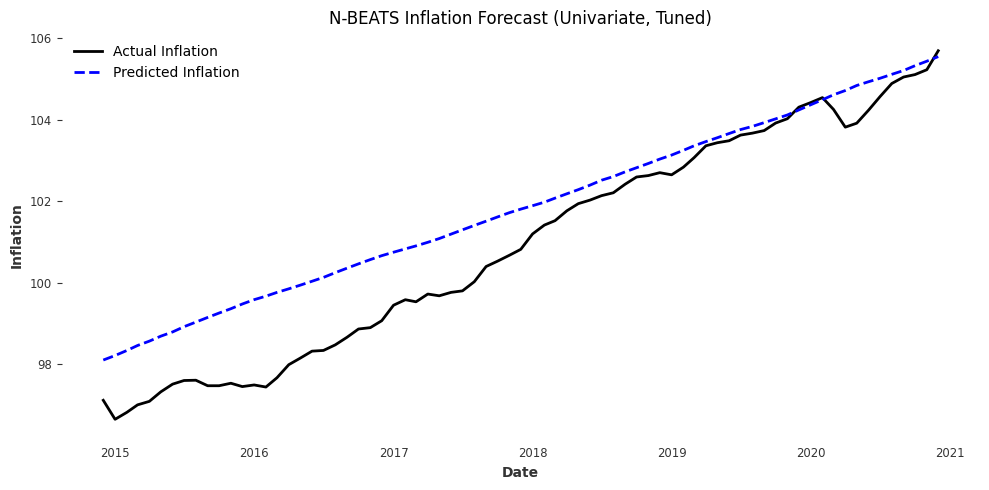

Validation MAPE: 0.94%
Validation RMSE: 1.1466


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from functools import reduce
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape, rmse
from sklearn.preprocessing import StandardScaler

# ===============================
# Load & Prepare Dataset
# ===============================
df = pd.read_csv("../Data/Train/train1990s.csv")
df["observation_date"] = pd.to_datetime(df["observation_date"], format="%m/%Y")
df = df.sort_values("observation_date")
df = df[["observation_date", "fred_PCEPI"]]

# Create TimeSeries
series = TimeSeries.from_dataframe(df, time_col="observation_date", value_cols="fred_PCEPI")

# Normalize using StandardScaler (trend-preserving)
scaler = Scaler(StandardScaler())
series_scaled = scaler.fit_transform(series)

# Define chunk lengths
input_len = 72
output_len = 3
min_required = input_len + output_len

# Safe train/val split
train = series_scaled[:-min_required]
val = series_scaled[-min_required:]

# ===============================
# N-BEATS Model Setup
# ===============================
model = NBEATSModel(
    input_chunk_length=input_len,
    output_chunk_length=output_len,
    n_epochs=10,
    batch_size=16,
    dropout=0.03,
    random_state=42,
    force_reset=True,
    optimizer_kwargs={"lr": 1e-3},
    nr_epochs_val_period=1,
    model_name="nbeats_final_univariate",
    pl_trainer_kwargs={
        "accelerator": "gpu" if torch.cuda.is_available() else "cpu",
        "enable_checkpointing": False,
    },
)

# ===============================
# Train the model
# ===============================
if len(val) >= min_required:
    model.fit(series=train, val_series=val, verbose=True)
else:
    print("⚠️ Validation series too short. Training without validation...")
    model.fit(series=train, verbose=True)

# ===============================
# Rolling Forecast on Validation
# ===============================
historical_preds = model.historical_forecasts(
    series=series_scaled,
    start=len(train),  # equivalent to start=0.9 dynamically
    forecast_horizon=output_len,
    stride=1,
    retrain=False,
    verbose=True
)

# Combine all predictions
forecast_series = reduce(lambda a, b: a.append(b), historical_preds)

# Inverse transform
forecast_inv = scaler.inverse_transform(forecast_series)
series_inv = scaler.inverse_transform(series_scaled)

# Align actual and prediction
actual_aligned = series_inv.slice_intersect(forecast_inv)

# ===============================
# Plot
# ===============================
plt.figure(figsize=(10, 5))
actual_aligned.plot(label="Actual Inflation", color="black")
forecast_inv.plot(label="Predicted Inflation", linestyle="dashed", color="blue")
plt.title("N-BEATS Inflation Forecast (Univariate, Tuned)")
plt.xlabel("Date")
plt.ylabel("Inflation")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# ===============================
# Evaluation
# ===============================
print(f"Validation MAPE: {mape(actual_aligned, forecast_inv):.2f}%")
print(f"Validation RMSE: {rmse(actual_aligned, forecast_inv):.4f}")
